## Part 1 implementing QAOA


In [1]:
!pip install wand

!apt install imagemagick

!pip install myqlm

!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 6.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    for i,j in edges:
      # val is the hamiltonian of the system, thus we add the product of sigma i and sigma j for all edges (i,j)
      val += (1-2*b[i])*(1-2*b[j])   
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

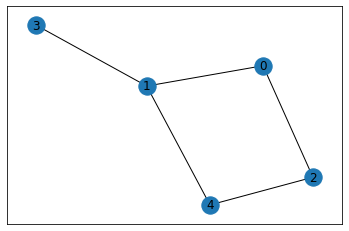

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [6]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for k in range(n_qubits):
      layer.apply(RX(theta),k)  # We apply a rotation of angle beta to each qubit 
    for i,j in edges :           # After some computation by hand we can see that applying the cost function hamiltonian is the same as applying Uzz to each vertex of all edges 
      layer.apply(U_ZZ(beta),i,j)
    return layer

### Question 4

In [7]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for i in range(n_qubits):
      prog.apply(H,qubits[i])                                                   #initialization : we apply an hadamard gate to all qubits
    for i in range(int(len(parameters)/2)) :
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*i], parameters[2*i+1]),qubits)           #parametrized circuit : we apply each qaoa layer successively with the parameters given 
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)

        b = sample.state.bitstring
        val = 0
        for i,j in edges :
          val += (1-2*int(b[i]))*(1-2*int(b[j]))                                # As in Q2 we compute the observable for each sample
        obs += sample.probability * val                                         # We compute the mean observable
    # END TODO
    return obs
    
        

In [8]:
import numpy as np
np.random.random(3)

array([0.36769014, 0.53422943, 0.53473805])

In [9]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
Réponse à la question: À partir de nlayers = 6 on voit que l'algorithme commence à converger, cependant la convergence reste aléatoire (pour 6 cela converge mais pour 7 non) puisque les paramètres d'entrée sont aléatoires. Cependant l'lagorithme reste plus efficace que l'algorithme classique.

-0.5982065375346156 -2.4239157118060892 -2.4636390474231304 -3.489774082627941 -4.1570005683445705 -4.30087696935644 -4.430663335207162 -4.589134133615018 -4.637465636129852 -4.7010833327663075 -4.731055267615449 -4.75911299693983 -4.772741951518742 -4.791793742952126 -4.809608142075859 -4.822000051182287 -4.840799473365308 -4.855666182332198 -4.864541530914141 -4.8744369616481285 -4.879099300708194 -4.880464788213681 -4.881828619739267 -4.8819464431203325 -4.881976934506841 -4.881982748775018 -4.881983356476833 -4.881984503808519 -4.881986668632629 -4.881990681782027 -4.881997799294155 -4.882009093993089 -4.882020310982669 -4.8820268437566705 -4.882033683820482 -4.882034847526856 -4.882035360656565 -4.882036149372738 -4.882037552981201 -4.882040168160849 -4.882045156242458 -4.882087607357074 -4.882443151567176 -4.882458867793289 -4.882974548014911 -4.8836585450364165 -4.884156166617767 -4.884738974162444 -4.885154623299102 -4.8882455025895375 -4.893313148259329 -4.895297815726828 -4.8

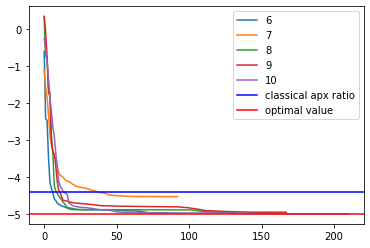

In [11]:
import matplotlib.pylab as plt


for nlayers in range(6,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

Explication du choix des paramètres dans l'algorithme : 

$e^{-i\int_0^T H(s)ds} = e^{-i \frac{T}{p} \sum_{k=1}^p H(\frac{Tk}{p})} = \prod_{k=1}^p e^{-i\frac{T}{p} (1 - \frac{k}{p}) \sum_i \sigma_x^i} e^{-i\frac{Tk}{p^2}H_c} = \prod_{k=1}^p RX(\theta_k) e^{-i\beta_k H_c}$

Par identification : $\theta_k = \frac{2T}{p}(1-\frac{k}{p})$ et $\beta_k = \frac{Tk}{p^2}$


-1.8599369066173035 -1.9792523697487014 -2.8654344066984394 -3.0939371111244993 -3.395025760787612 -3.7329978496527323 -3.889355433882277 -3.9693434799371943 -3.977424098471434 -3.9781781794961715 -3.9782686622876158 -3.978269027568936 -3.97826902965222 -3.9782690296564724 -1.7485106703326065 -1.8144011265135445 -2.3172780679458076 -3.2096705861895183 -3.6092504612106002 -3.8870468817080273 -4.248442765396564 -4.424086643329558 -4.494829694422574 -4.575615639975264 -4.63138587051854 -4.651671306310404 -4.66176660266787 -4.662433825622503 -4.662568180699104 -4.662589557638748 -4.662589583785779 -4.66258958828735 -1.6251857179019253 -2.2735140499915425 -2.9833992719484583 -3.3955254880636128 -4.116335846495604 -4.378782833833872 -4.433853000603348 -4.50845809133071 -4.528756287050583 -4.564470307255118 -4.624283500296796 -4.657136667551608 -4.666535165902283 -4.674531831963444 -4.687682422329888 -4.704475219462517 -4.710923527098481 -4.714145347189767 -4.714844792459342 -4.71519018245974

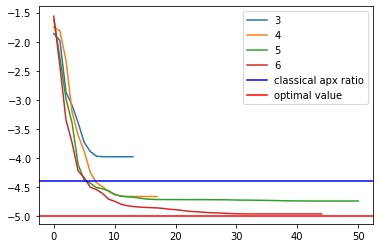

In [16]:
T = 1.

for nlayers in range(3,7,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range (nlayers):
      parameters_init.append(T/nlayers*(1-i/nlayers)*2)                         #Compute the theta coefficient
      parameters_init.append(T*i/(nlayers**2))                                  #Compute the beta coefficient 
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

On voit que la convergence est nettement plus rapide, dès 4 layers on a des meilleures performances que l'algorithme classique. A partir de 6 layers on atteint la valeur optimale. 

-0.8126041072635957 -1.2072616371328666 -1.9587056823766036 -2.5640698033311398 -2.9155238979165463 -3.1079420643986935 -3.206502652143127 -3.31886551641864 -3.4125039900060377 -3.5438391471984607 -3.586180366177297 -3.5944489843505814 -3.595701634425584 -3.5957420343479534 -3.5957440576717197 -3.5957440581315834 -2.5122011159839044 -2.896955316286939 -2.939559113164728 -3.016501296929048 -3.1357395343666092 -3.2891890867480664 -3.511288600551369 -3.5705688706848933 -3.59811650593659 -3.6205898334979345 -3.635856951342875 -3.6467765590452252 -3.648036911434316 -3.648249091583184 -3.648263452699018 -3.6482678711542547 -3.648267928968146 -3.648267931146946 -3.6482679312161945 -3.6482679313191584 -3.648267931509554 -3.648267931873401 -3.6482679348332647 -3.6482679404774183 -3.6482687209990323 -3.648268742463795 -3.648271325074783 -3.6482760604061544 -3.6482850402694877 -3.6483011607622573 -3.648327871811107 -3.648373754271705 -3.648456071286946 -3.648602638634479 -3.64884498761609 -3.6491

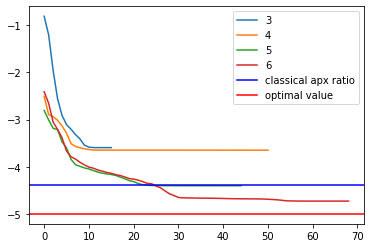

In [18]:
T = 5.

for nlayers in range(3,7,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range (nlayers):
      parameters_init.append(T/nlayers*(1-i/nlayers)*2)
      parameters_init.append(T*i/(nlayers**2))
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

Pour un T plus grand ici 5, les performances ont moins bonnes : 6 layers ne convergent pas vers la solution optimale et les performances ne sont meilleures que celle de l'algo classique qu'à partir de 5 layers.